In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
# define file paths
directory = "results/scores-on-random-alpha-complexes"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))

100%|██████████| 809/809 [00:01<00:00, 567.91it/s] 


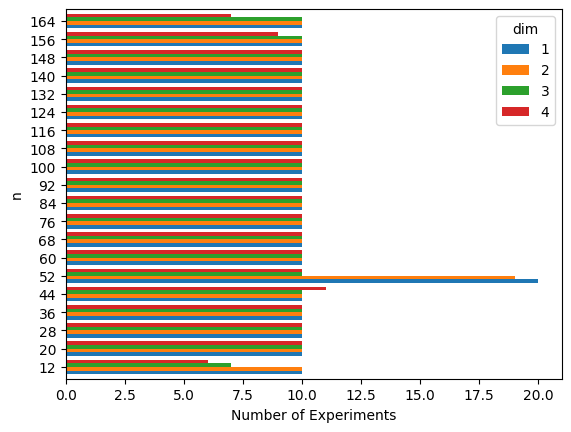

In [4]:
df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/scores - cases.png')

In [5]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (809, 8)


,index,n,dim,points,stree,depth poset,poset scores,node scores
0,0,52,1,"[[0.8488740863985977], [0.8390931417085878], [...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f2a3536d090>,"[{'object': 'full', 'number_of_nodes': 51, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
1,1,52,1,"[[0.6702359828710381], [0.6781144249132769], [...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f2a353fcb10>,"[{'object': 'full', 'number_of_nodes': 51, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
2,2,52,1,"[[0.4374300663599222], [0.9079315855637595], [...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f2a353ff8d0>,"[{'object': 'full', 'number_of_nodes': 51, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
3,3,52,1,"[[0.2934639083892395], [0.06332515699097896], ...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f2a3540b210>,"[{'object': 'full', 'number_of_nodes': 51, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."
4,4,52,1,"[[0.708657884991437], [0.021743018703327954], ...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f2a35416c90>,"[{'object': 'full', 'number_of_nodes': 51, 'nu...","[{'object': 'full', 'node': ShallowPair([0.000..."


# Analyze Perststance Distribution

There are 0 zero peristsance pairs calculated.


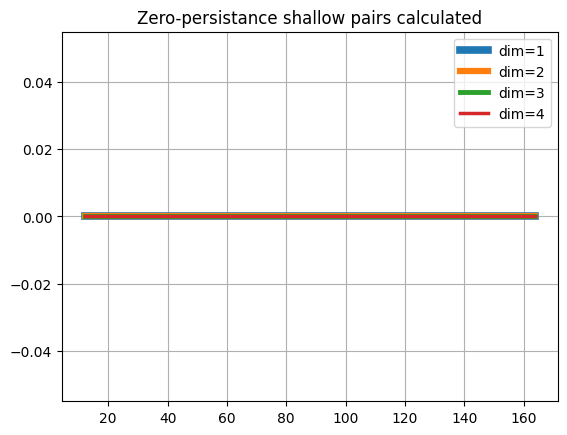

In [6]:
persistance = pd.Series([[n.death_value - n.birth_value for n in dp.nodes] for dp in df_cases['depth poset']], index=df_cases.index)

print(f'There are {(np.concatenate(persistance) == 0).sum()} zero peristsance pairs calculated.')

plt.title('Zero-persistance shallow pairs calculated')

df_cases['persistance'] = persistance
df_cases['zero persistance'] = [(np.array(p) == 0).sum() for p in persistance]

for i, dim in enumerate(pd.unique(df_cases['dim'])):
    plt.plot(df_cases[df_cases['dim'] == dim][['n', 'zero persistance']].groupby(['n']).mean(), label=f'dim={dim}', linewidth=5.5 - i)
plt.grid(True)
plt.legend()
plt.show()

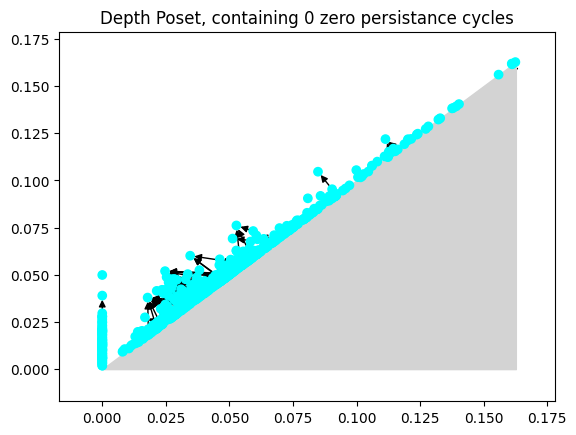

In [7]:
try:
    i = np.random.choice(df_cases[df_cases['zero persistance'] != 0].index)
except ValueError:
    i = np.random.choice(df_cases.index)
dp = df_cases.loc[i, 'depth poset']

plt.title(f"Depth Poset, containing {df_cases.loc[i, 'zero persistance']} zero persistance cycles")

node_color = np.array(['cyan', 'gold'])[(np.array(df_cases.loc[i, 'persistance']) == 0).astype(int)]
draw_networkx(dp.get_transitive_reduction(), pos=dp.persistant_layout(), node_color=node_color, node_size=36, with_labels=False, hide_ticks=False)
plt.fill_between([0, max(dp.get_filtration_values())], [0, max(dp.get_filtration_values())], [0, 0], color='lightgrey')

plt.show()

# Are they Trees

In [8]:
df_cases['is tree'] = [nx.is_tree(dp.get_transitive_reduction()) for dp in tqdm(df_cases['depth poset'], total=len(df_cases))]

print(f"There are {df_cases['is tree'].count() - df_cases['is tree'].sum()}/{df_cases['is tree'].count()} depth posets are not trees.")

100%|██████████| 809/809 [00:05<00:00, 160.80it/s] 

There are 808/809 depth posets are not trees.


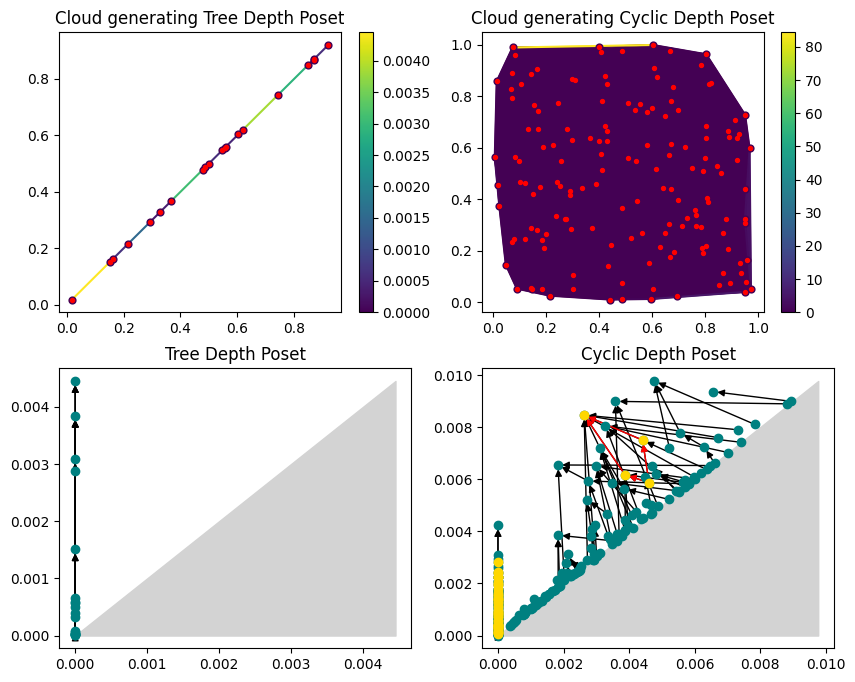

In [33]:
try:
    id_tree = np.random.choice(df_cases[df_cases['is tree']&(df_cases['dim'] <= 2)].index)
    dp_tree = df_cases.loc[id_tree, "depth poset"]
    st_tree = df_cases.loc[id_tree, "stree"]
    ps_tree = df_cases.loc[id_tree, "points"]
except ValueError as msg:
    print(f'Not found tree depth poset: {msg}')
    dp_tree = DepthPoset()
    st_tree = gh.SimplexTree()
    ps_tree = []
try:
    id_cyclic = np.random.choice(df_cases[(~df_cases['is tree'])&(df_cases['dim'] <= 2)].index)
    dp_cyclic = df_cases.loc[id_cyclic, "depth poset"]
    st_cyclic = df_cases.loc[id_cyclic, "stree"]
    ps_cyclic = df_cases.loc[id_cyclic, "points"]
except ValueError as msg:
    print(f'Not found cyclic depth poset: {msg}')
    dp_cyclic = DepthPoset()
    st_cyclic = gh.SimplexTree()
    ps_cyclic = []

titles = ["Tree", "Cyclic"]
dps = [dp_tree, dp_cyclic]
sts = [st_tree, st_cyclic]
pss = [ps_tree, ps_cyclic]


cmap = plt.get_cmap("viridis")

fig, axs = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(10)

for i in range(2):
    axs[0, i].set_title(f'Cloud generating {titles[i]} Depth Poset')
    points, stree = pss[i], sts[i]

    norm = Normalize(vmin=0, vmax=max([value for simplex, value in stree.get_filtration()]))
    for simplex, value in stree.get_filtration():
        color = cmap(norm(value))
        if len(simplex) == 1:
            x, y = points[simplex][0]*np.ones(2)
            axs[0, i].scatter(x, y, color=color, s=24, zorder=2)
            axs[0, i].scatter(x, y, color='red', s=8, zorder=3)
        if len(simplex) == 2:
            x, y = np.transpose(points[simplex]*np.ones([2, 2]))
            axs[0, i].plot(x, y, color=color, zorder=1)
        if len(simplex) == 3:
            x, y = points[simplex].transpose()
            axs[0, i].fill(x, y, color=color, zorder=0)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[0, i])

    axs[1, i].set_title(f'{titles[i]} Depth Poset')

    g = dps[i].get_transitive_reduction().to_undirected()
    cycles = nx.cycle_basis(g)
    if len(cycles) == 0:
        cycle_nodes = []
        cycle_edges = []
    else:
        cycle_nodes = [] if len(cycles) == 0 else np.concatenate(cycles)
        cycle_edges = np.concatenate([np.array([cycle, np.append(cycle[1:], cycle[0])]) for cycle in cycles], axis=1)
        cycle_edges = np.concatenate([cycle_edges, [cycle_edges[1], cycle_edges[0]]], axis=1).transpose()
        cycle_edges = [tuple(edge) for edge in cycle_edges]
    node_condition = lambda node: node in cycle_nodes
    edge_condition = lambda edge: edge in cycle_edges

    nx.draw_networkx(dps[i].get_transitive_reduction(), 
                     pos=dps[i].persistant_layout(), ax=axs[1, i], 
                     node_color='teal', edge_color='black',
                     node_size=36, with_labels=False, hide_ticks=False)
    nx.draw_networkx(dps[i].subposet(node_condition=node_condition, edge_condition=edge_condition).get_transitive_reduction(), 
                     pos=dps[i].persistant_layout(), ax=axs[1, i], 
                     node_color='gold', edge_color='red',
                     node_size=36, with_labels=False, hide_ticks=False)
    
    axs[1, i].fill_between([0, max(dps[i].get_filtration_values())], [0, max(dps[i].get_filtration_values())], [0, 0], color='lightgrey')
    axs[1, i].set_xlim(*(np.max(dps[i].get_filtration_values())*np.array([-0.05, 1.05])))
    axs[1, i].set_ylim(*(np.max(dps[i].get_filtration_values())*np.array([-0.05, 1.05])))

plt.show()

# Plot Poset scores

In [10]:
df_poset_scores = [pd.DataFrame(i['poset scores']) for i in ls]
for i in range(len(df_poset_scores)):
    df_poset_scores[i].insert(0, 'index', value=i)
df_poset_scores = pd.concat(df_poset_scores)

df_poset_scores = df_cases[['index', 'n', 'dim']].join(df_poset_scores.set_index('index'), on='index')

print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

df_poset_scores.shape = (2800, 11)


,index,n,dim,object,number_of_nodes,number_of_minimal_nodes,number_of_maximal_nodes,height,width,minimum_maximal_chain,avarage_maximal_chain
0,0,52,1,full,51,25,5,5,26,2,3.566667
0,0,52,1,subposet dim=0,51,25,5,5,26,2,3.566667
1,1,52,1,full,51,21,4,4,21,2,3.846154
1,1,52,1,subposet dim=0,51,21,4,4,21,2,3.846154
2,2,52,1,full,51,26,3,5,26,2,3.852941


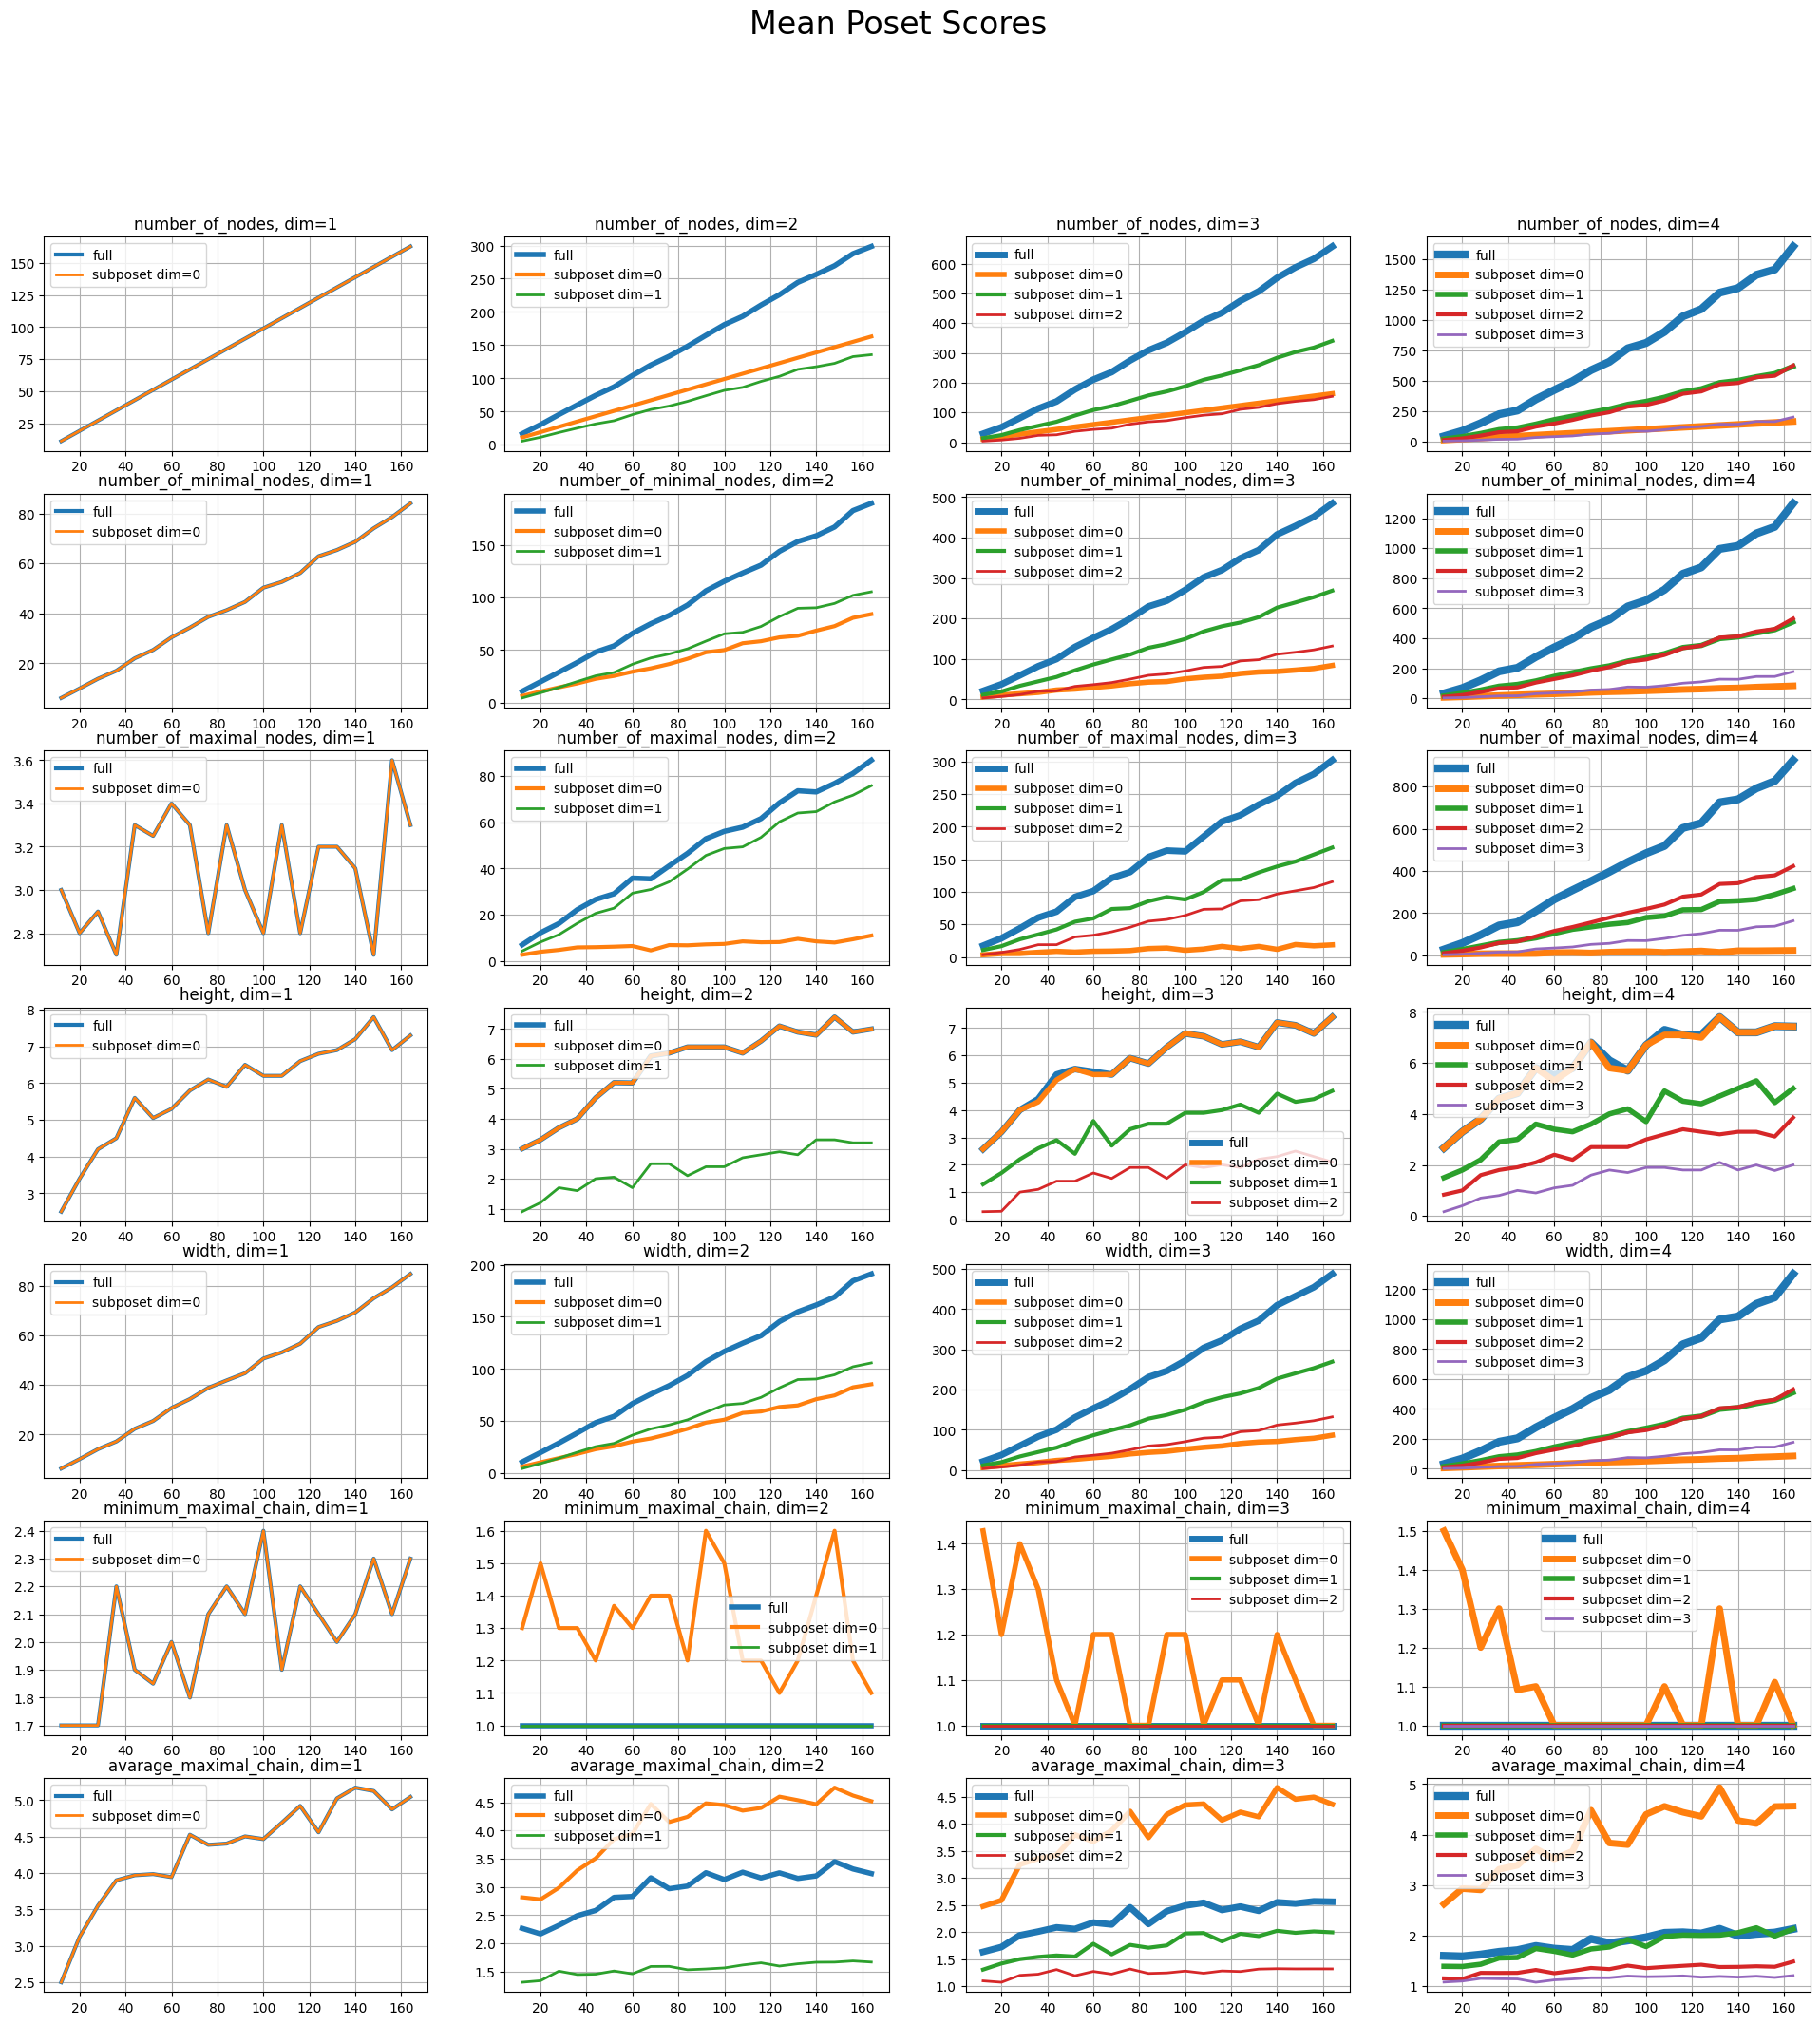

In [11]:
score_cols = df_poset_scores.columns[4:]
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Poset Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
#plt.tight_layout()
plt.savefig('raports/pics/scores - mean poset scores.png')

# Plot Node Scores

In [12]:
df_node_scores = [pd.DataFrame(i['node scores']) for i in ls]
for i in range(len(df_node_scores)):
    df_node_scores[i].insert(0, 'index', value=i)
df_node_scores = pd.concat(df_node_scores)


df_node_scores = df_cases[['index', 'n', 'dim']].join(df_node_scores.set_index('index'), on='index')

print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

df_node_scores.shape = (25780, 12)


,index,n,dim,object,node,incomparable_number,ancestors_number,ancestors_height,ancestors_width,successors_number,successors_height,successors_width
0,0,52,1,full,"ShallowPair([0.0000, 0.0055], dim=0)",36,0,0,0,14,4,7
0,0,52,1,subposet dim=0,"ShallowPair([0.0000, 0.0055], dim=0)",36,0,0,0,14,4,7
0,0,52,1,full,"ShallowPair([0.0000, 0.0000], dim=0)",45,5,4,1,0,0,0
0,0,52,1,subposet dim=0,"ShallowPair([0.0000, 0.0000], dim=0)",45,5,4,1,0,0,0
0,0,52,1,full,"ShallowPair([0.0000, 0.0000], dim=0)",46,4,3,1,0,0,0


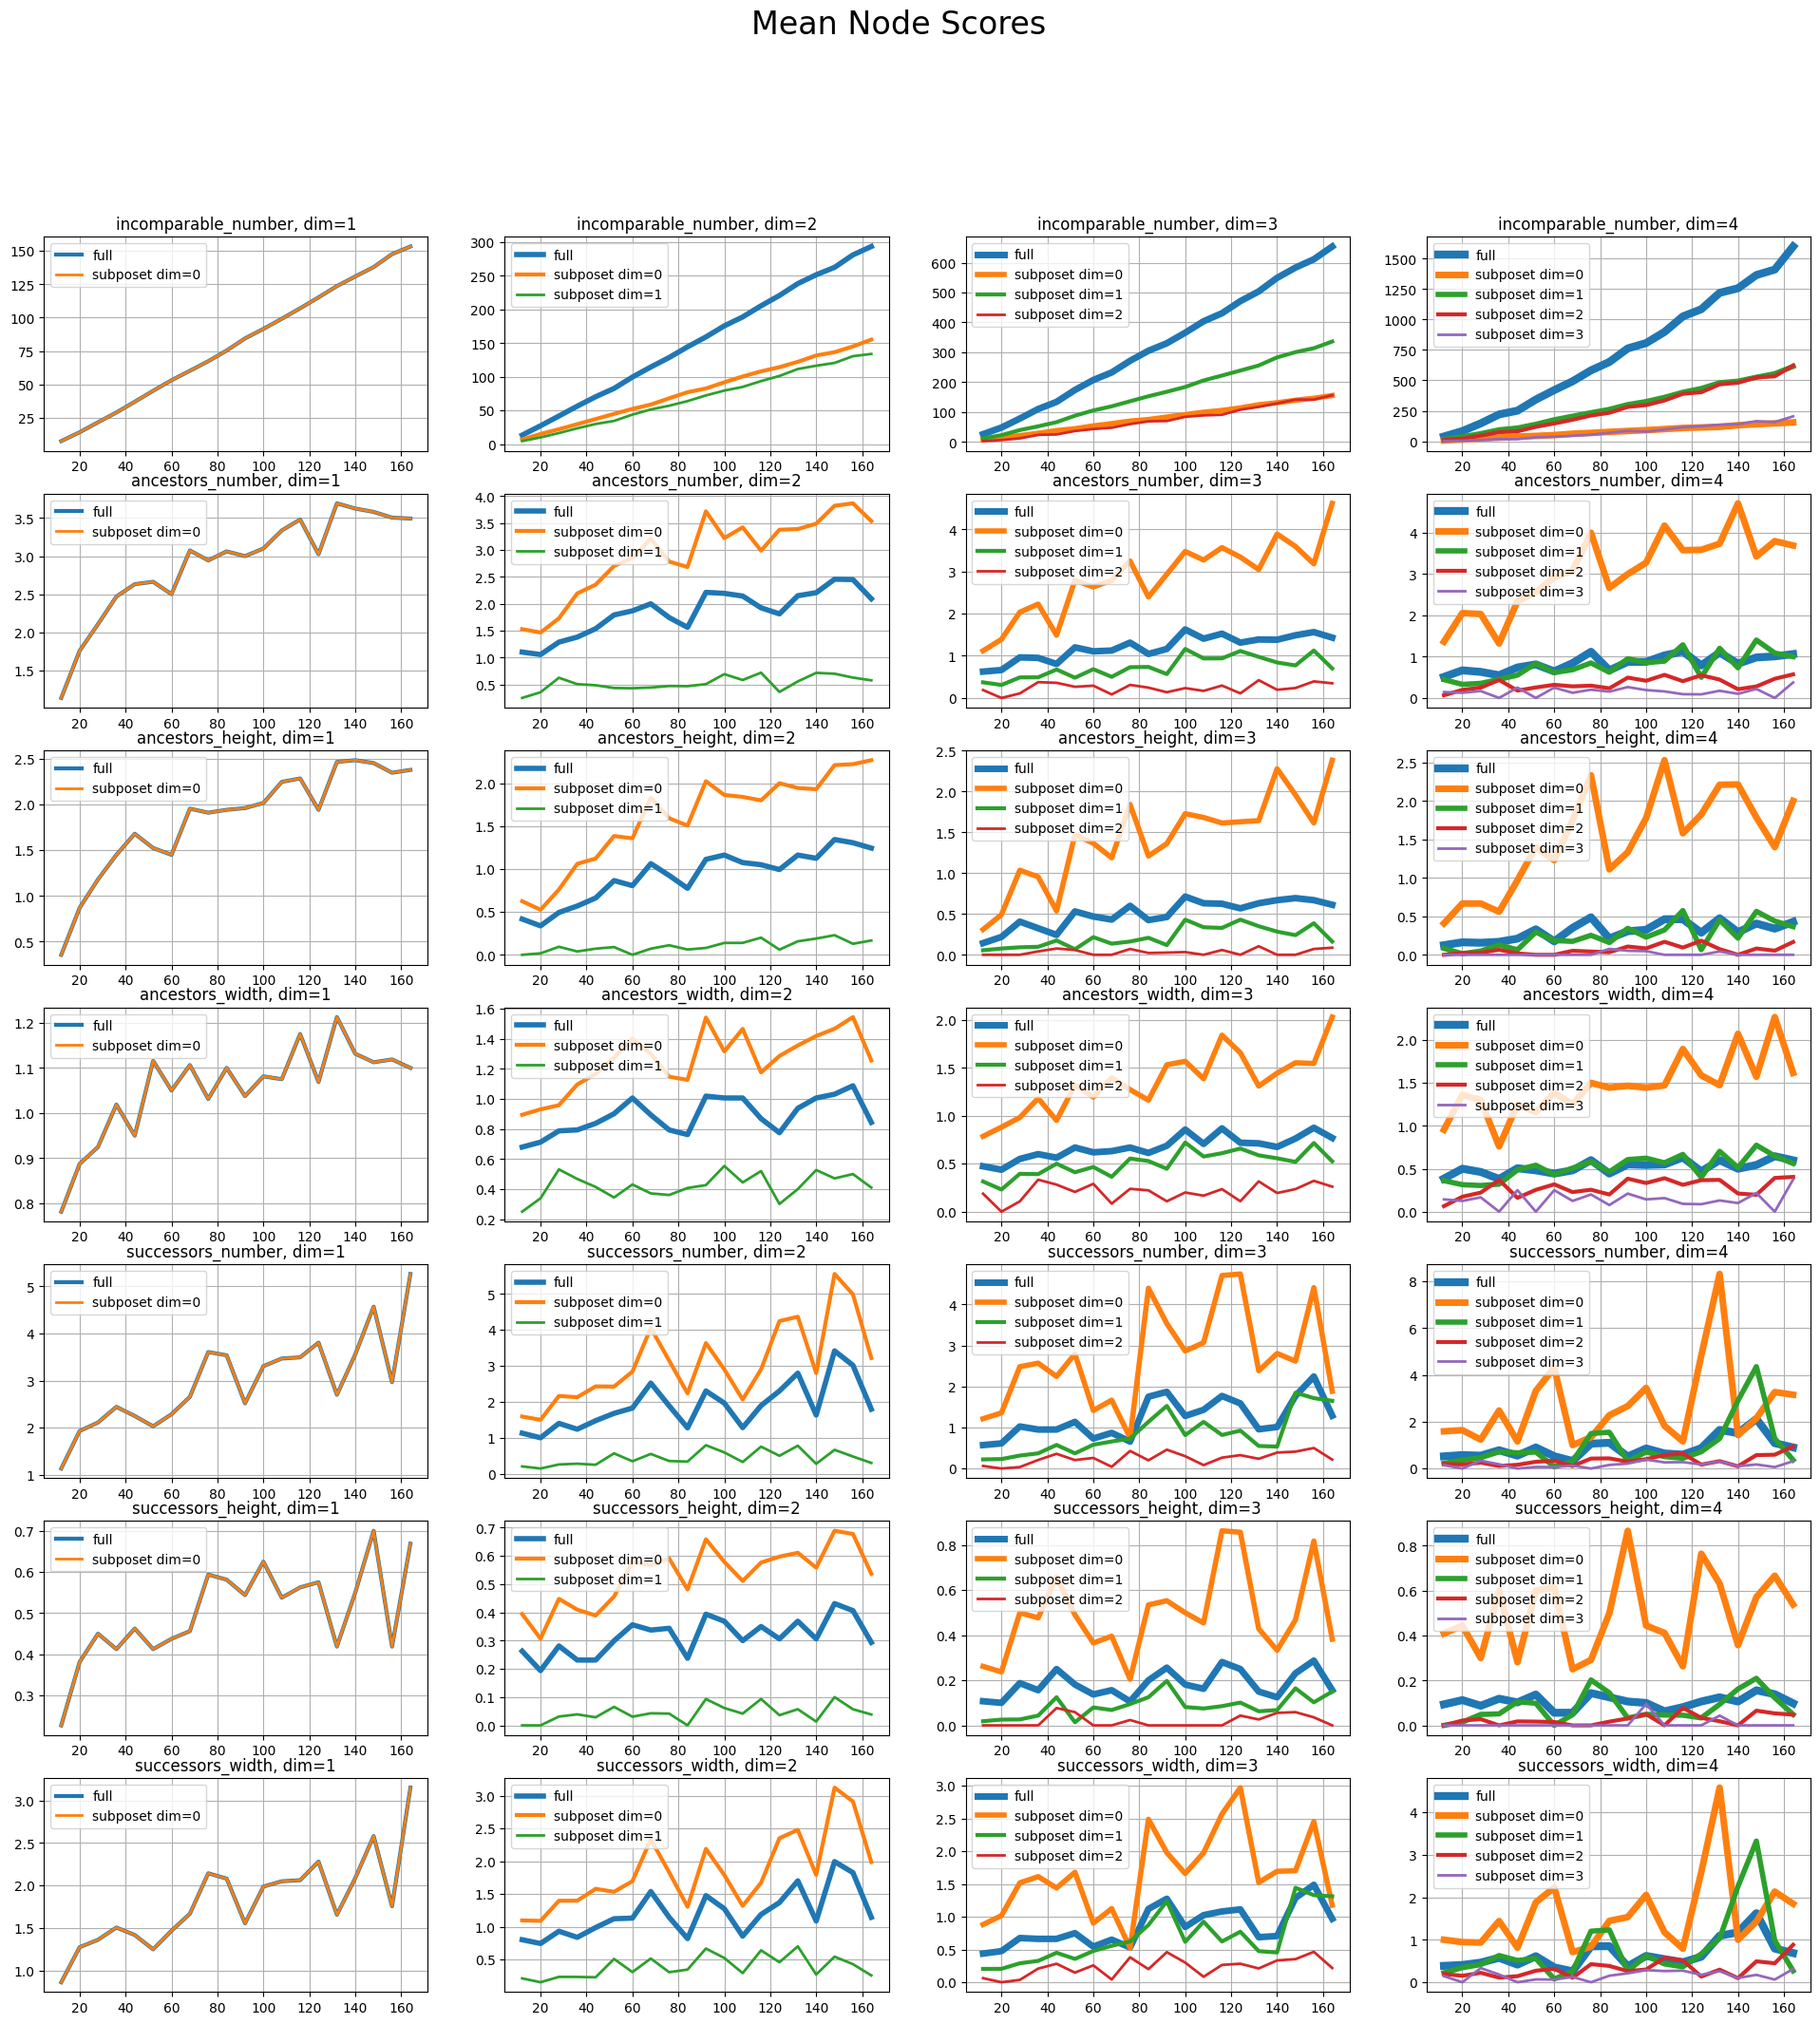

In [13]:
score_cols = df_node_scores.columns[5:]
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Node Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
#plt.tight_layout()
plt.savefig('raports/pics/scores - mean node scores.png')

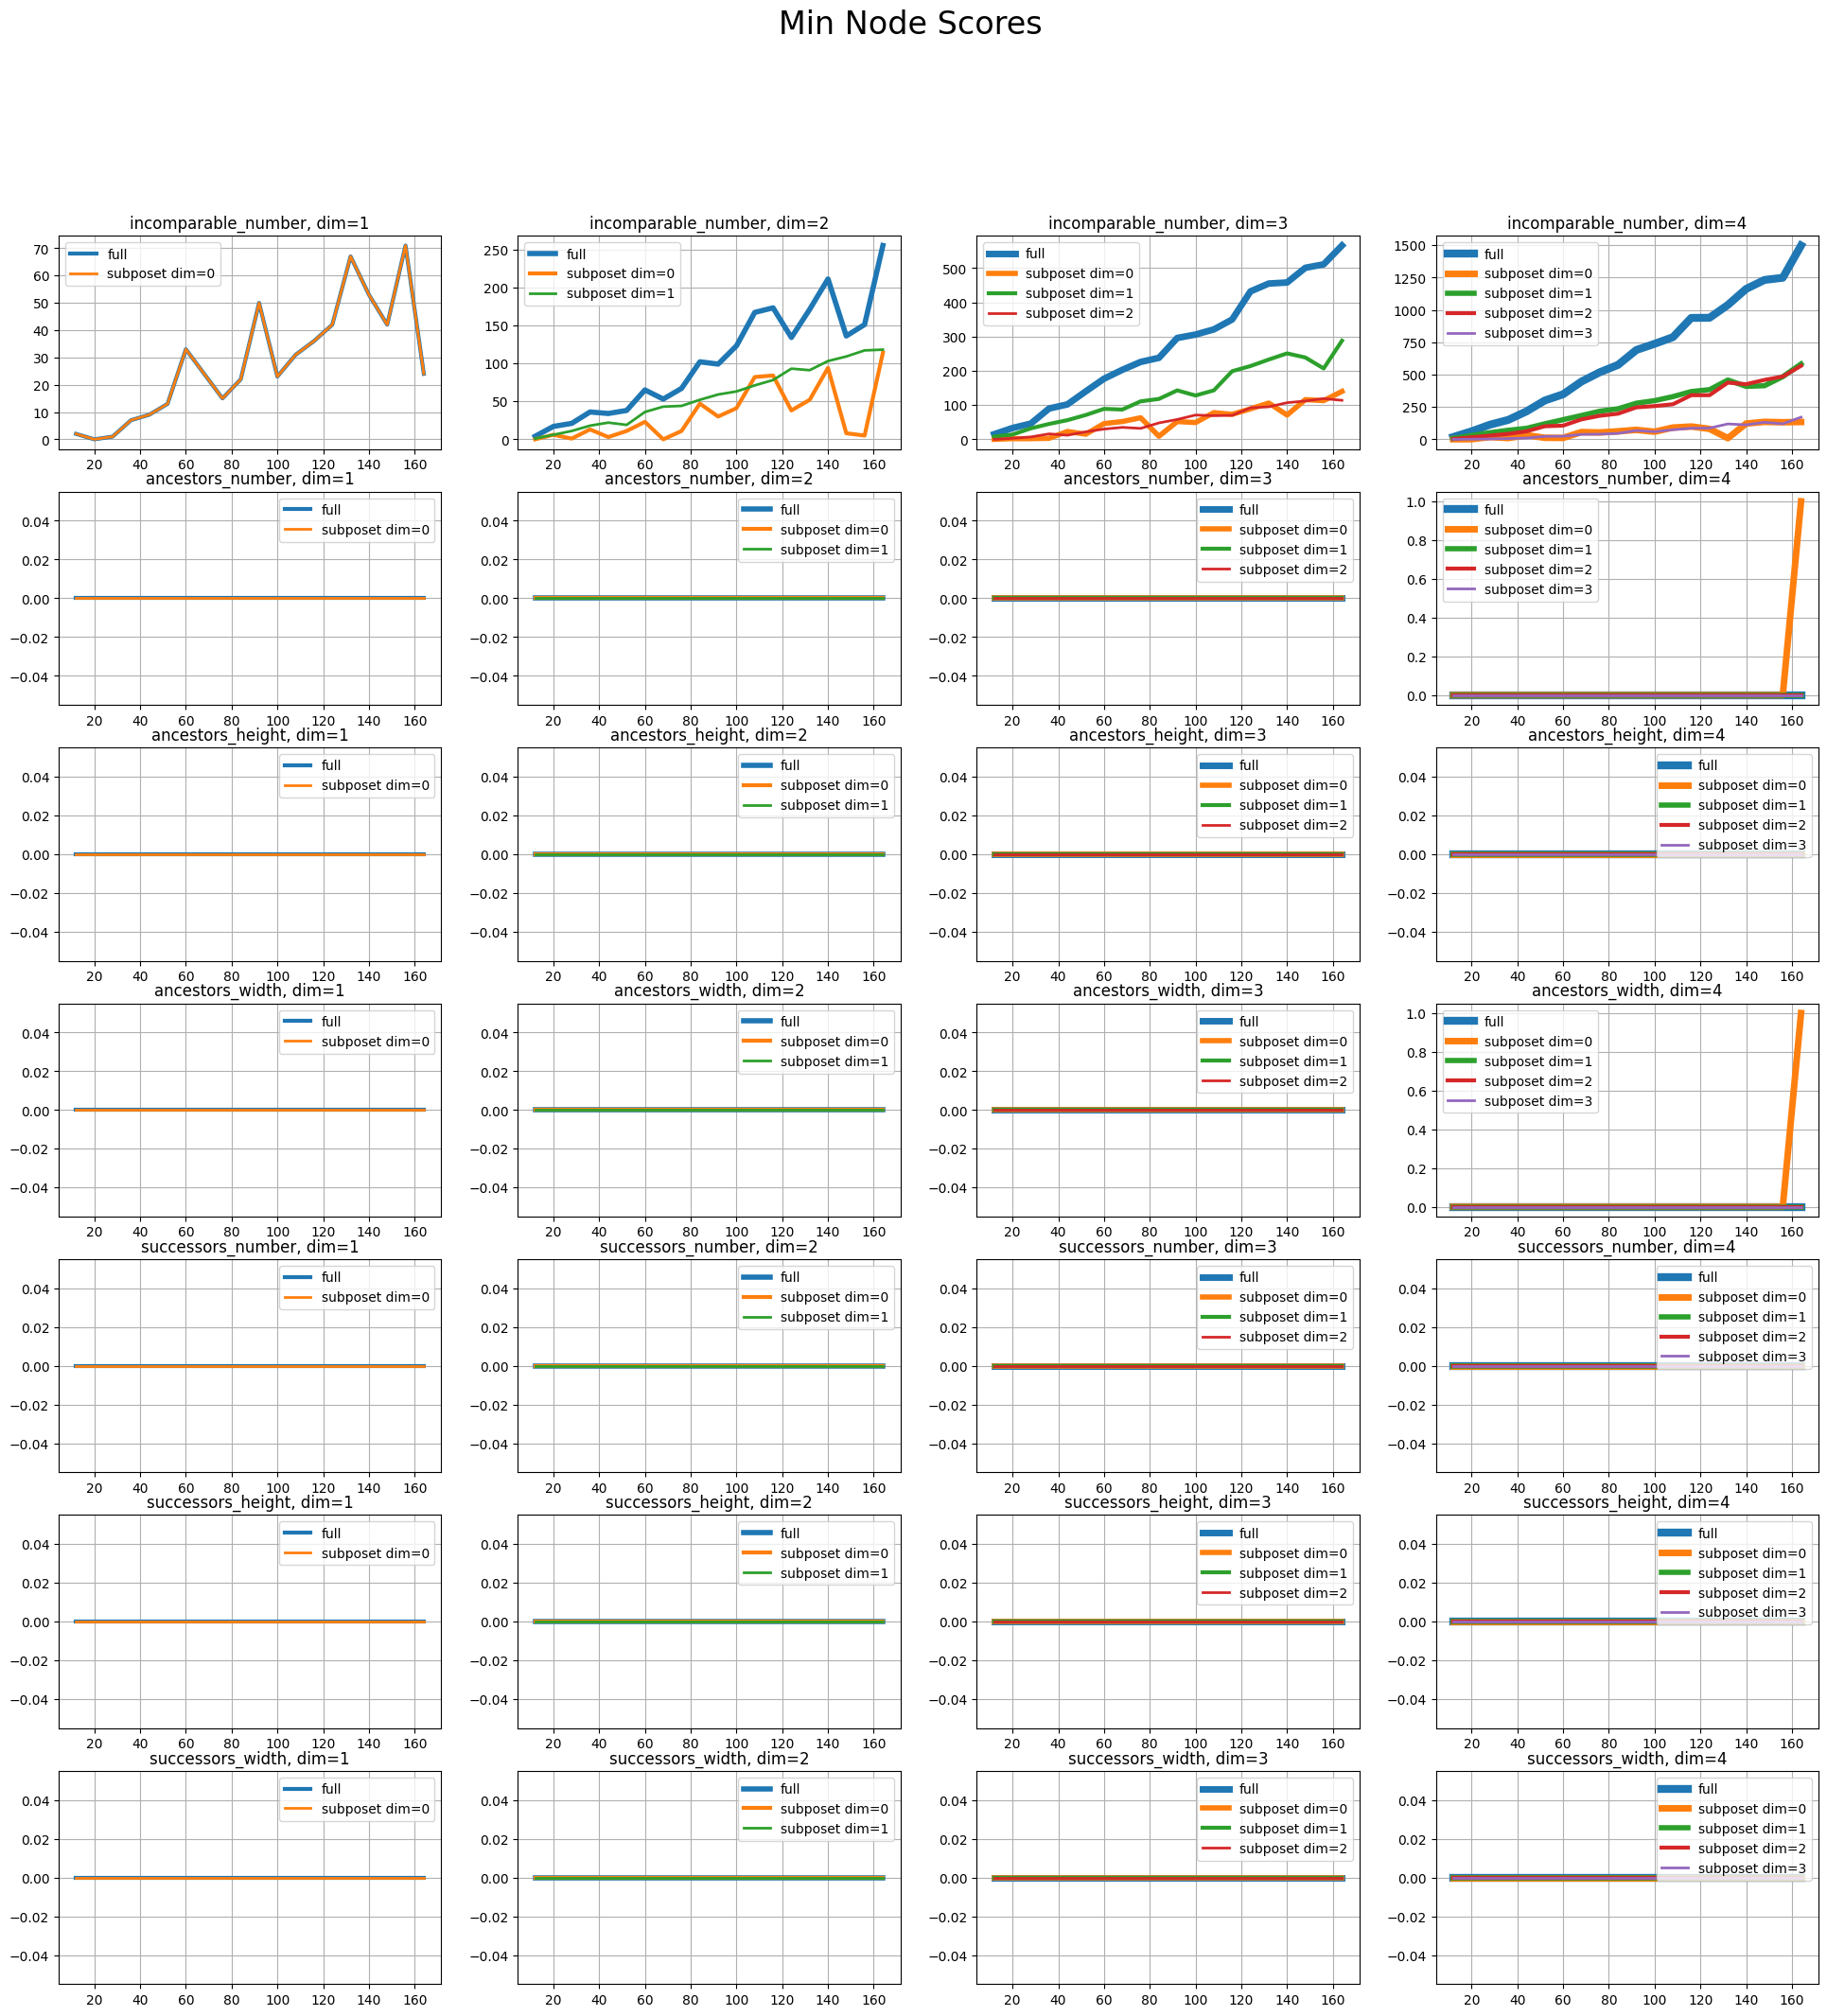

In [14]:
score_cols = df_node_scores.columns[5:]
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Min Node Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).min().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
#plt.tight_layout()
plt.savefig('raports/pics/scores - min node scores.png')

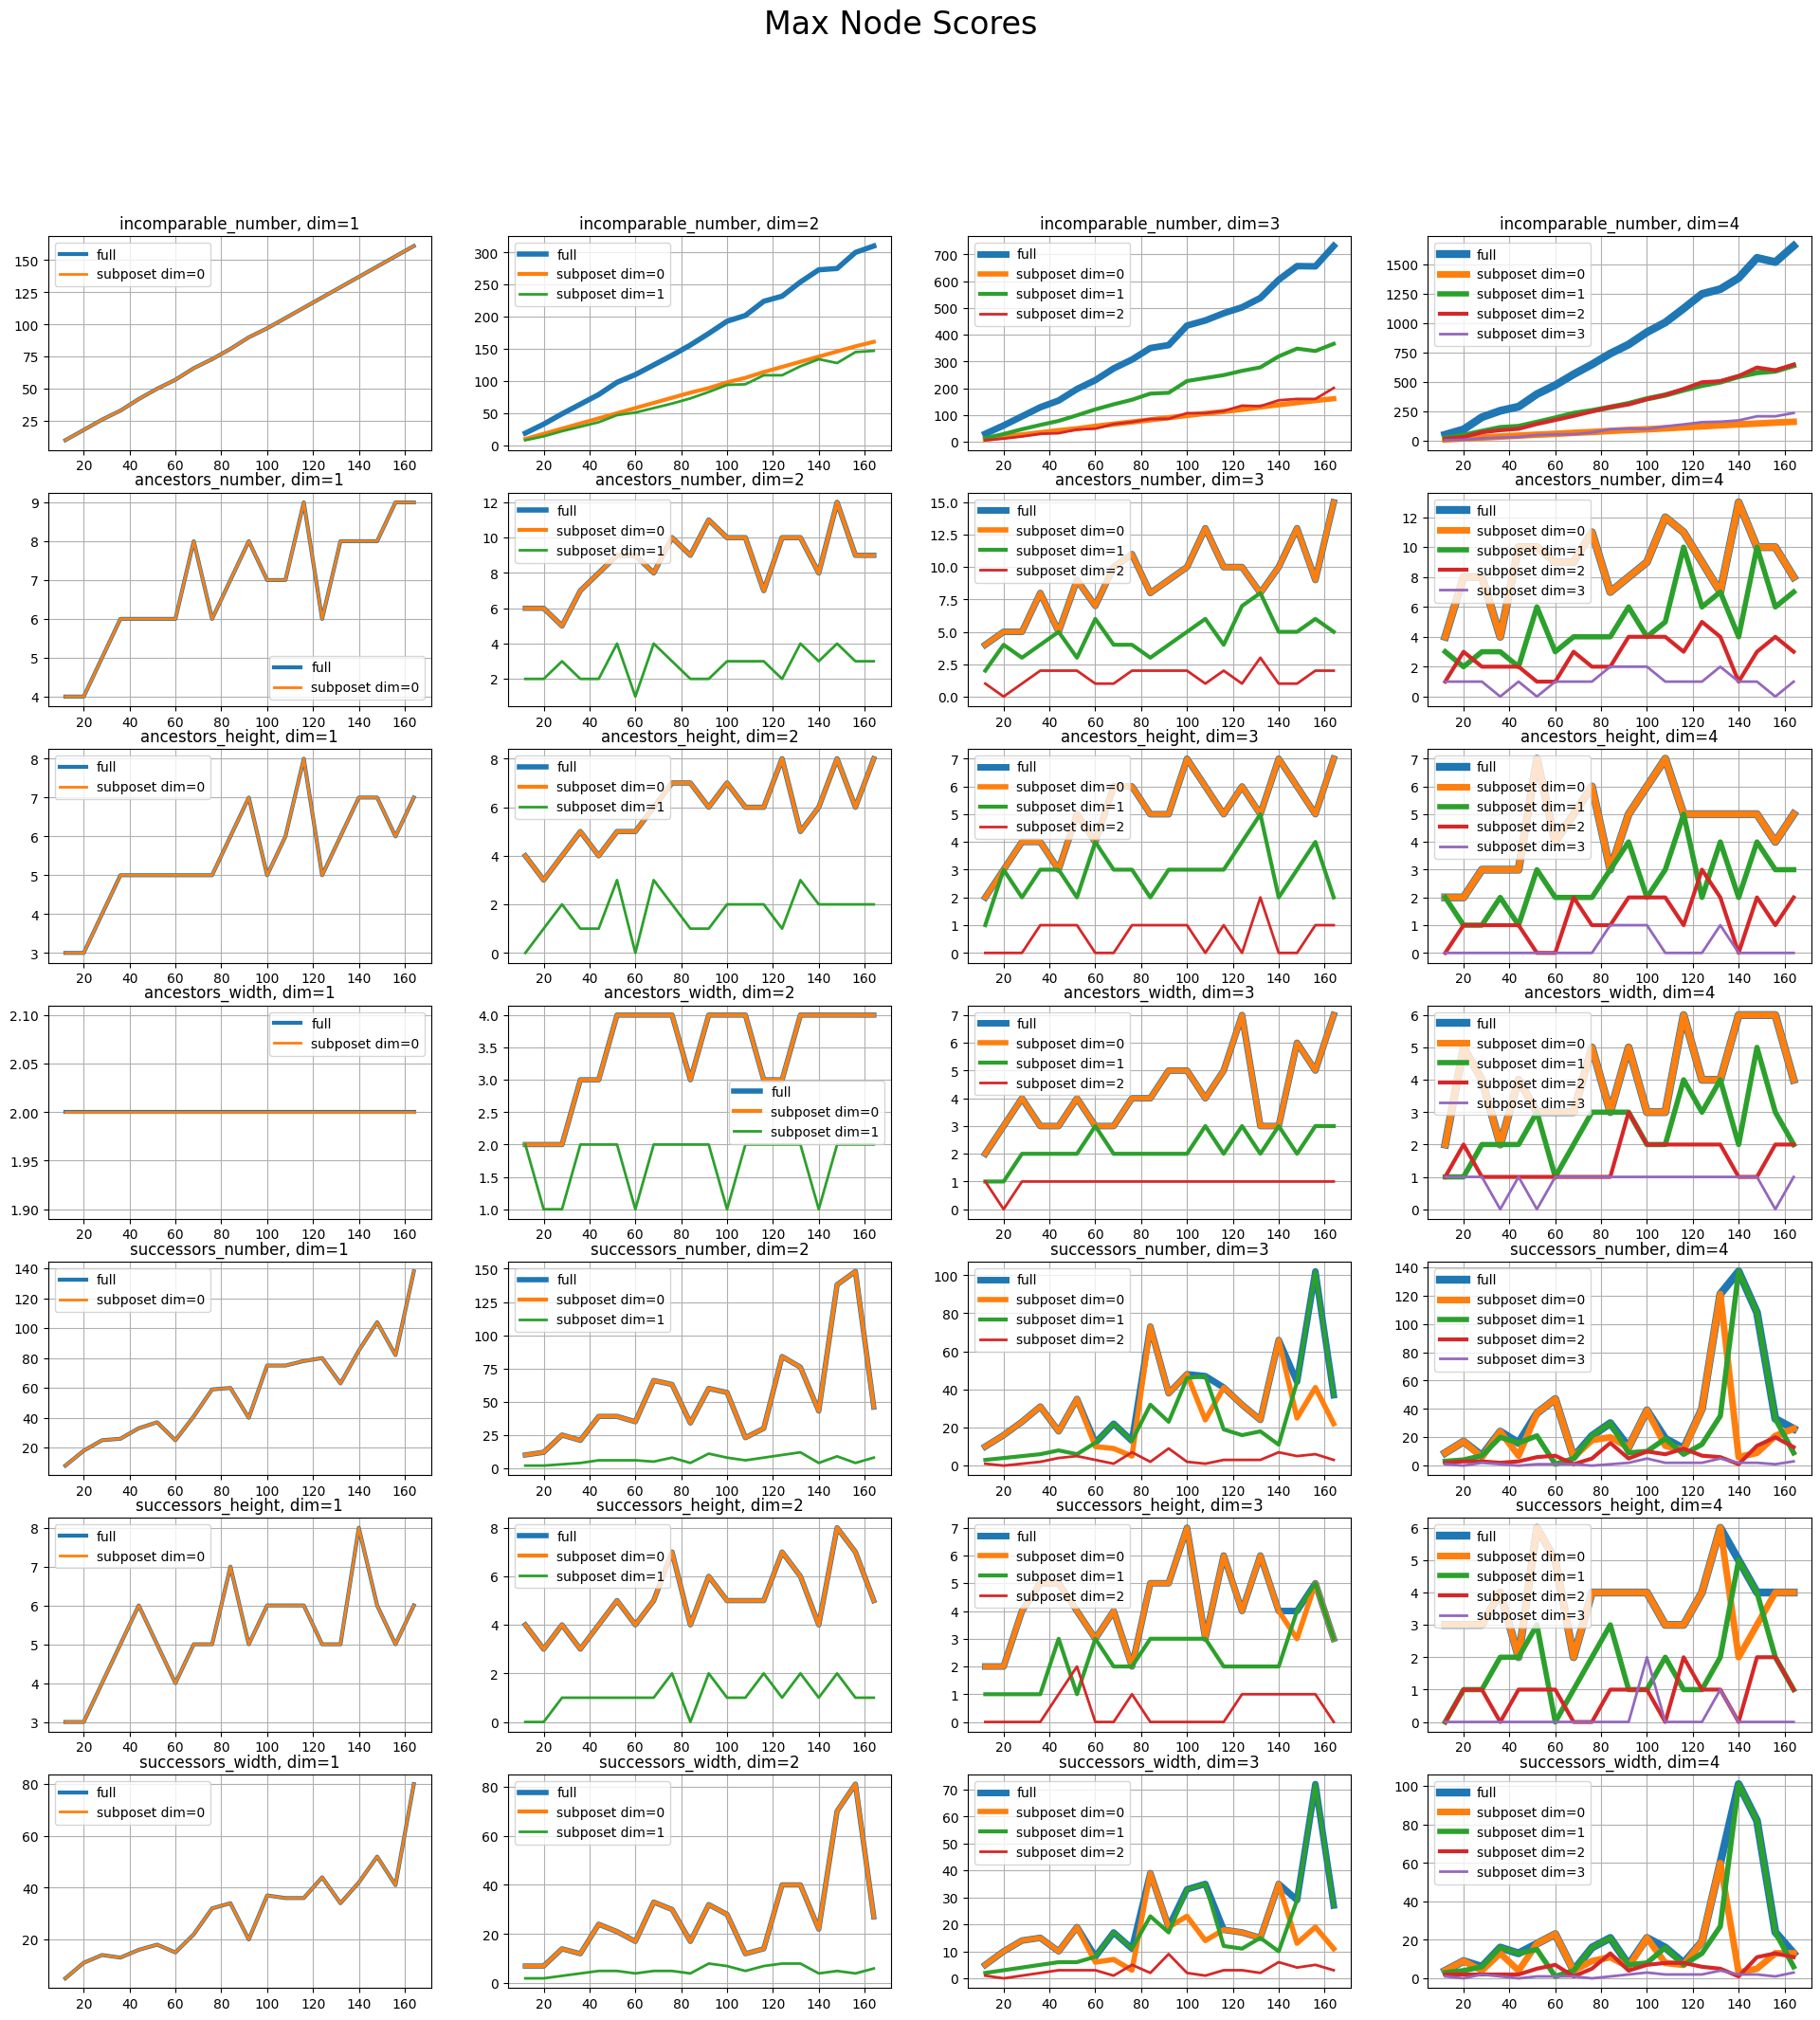

In [15]:
score_cols = df_node_scores.columns[5:]
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Max Node Scores', fontsize=24)
fig.set_figwidth(24)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).max().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
#plt.tight_layout()
plt.savefig('raports/pics/scores - max node scores.png')

# Compile Raport Document

In [16]:
import src.poset_scores as poset_scores
import src.node_scores as node_scores
import inspect

In [17]:
def href_links(s: str, text='link') -> str:
    # replacing links in string with LaTeX format
    for w in s.split():
        if w[:6] == r'https:':
            if text is None:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{w}}}'.replace('_', r'\_'))
            else:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{text}}}')
    return s

In [18]:
# poset_scores description
s_poset_scores = r'\begin{itemize}' + '\n'

for name, obj in inspect.getmembers(poset_scores, inspect.isfunction):
    if obj.__module__ == poset_scores.__name__:
        s_poset_scores += r"\item \textbf{" + name.replace('_', r'\_') + " }: " + href_links(obj.__doc__.strip()) + "\n"
s_poset_scores += r'\end{itemize}'

print(s_poset_scores)

\begin{itemize}
\item \textbf{avarage\_maximal\_chain }: Returns the avarage size of maximal chains in the poset.
\item \textbf{height }: Returns the poset height - the length of the longest chain.
\item \textbf{minimum\_maximal\_chain }: Returns the minimum size of maximal chains in the poset.
\item \textbf{number\_of\_edges\_in\_closure }: Returns the number of nodes in the poset transitive closure.
\item \textbf{number\_of\_edges\_in\_reduction }: Returns the number of nodes in the poset transitive reduction.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{width }: Returns the poset width - the length of the longest antichain (subset, s.t. all elements are pairwise incomparable).
    The algorithm is based on Dilworth's theorem and it's proof via Kőnig's theorem:
    \href{https://

In [19]:
# node_scores description
s_node_scores = r'\begin{itemize}' + '\n'

for name, obj in inspect.getmembers(node_scores, inspect.isfunction):
    if obj.__module__ == node_scores.__name__:
        s_node_scores += r"\item \textbf{" + name.replace('_', r'\_') + "}: " + href_links(obj.__doc__.strip()) + "\n"
s_node_scores += r'\end{itemize}'

print(s_node_scores)

\begin{itemize}
\item \textbf{ancestors\_height}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_number}: Returns the number of nodes higher than given
\item \textbf{ancestors\_width}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{incomparable\_number}: Returns the number of incomparable elements for given node
\item \textbf{successors\_height}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_number}: Returns the number of nodes higher than given
\item \textbf{successors\_width}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\end{itemize}


In [20]:
# load texts, describing the process
with open('texts/scores - model.txt', 'r') as file:
    s_model = file.read()

with open('texts/scores - conclusion.txt', 'r') as file:
    s_coclusion = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [21]:
# parameters to include pictures containing scores
vspace_pt = -108
resize_width = 1.96
hspace_width = min(0, 0.5*(1 - resize_width))


body = f"""
\\section{{Model}}
{s_model}

\\section{{Scores}}
\\subsection{{Poset Scores}}
{s_poset_scores}

\\subsection{{Node Scores}}
{s_node_scores}

\\section{{Experiments and Results}}
\\par There are {len(df_cases)} experiments done. In the Figure \\ref{{fig:cases_distribution}} we can see how cases are distributed by size and dimension.
\\begin{{figure}}[ht]
  \\centering
  \\includegraphics[width=\\textwidth]{{pics/scores - cases.png}}
  \\caption{{Size/dimension distribution of experiments}}
  \\label{{fig:cases_distribution}}
\end{{figure}}

\\par In the Figure \\ref{{fig:scores_poset_mean}} we can see the avarage poset scores values for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean poset scores.png}}}}
  \\caption{{Mean poset scores}}
  \\label{{fig:scores_poset_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean}} we can see the avarage mean node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean node scores.png}}}}
  \\caption{{Mean node scores}}
  \\label{{fig:scores_node_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_max}} we can see the avarage maximum node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - max node scores.png}}}}
  \\caption{{Max node scores}}
  \\label{{fig:scores_node_max}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_min}} we can see the avarage minimum node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - min node scores.png}}}}
  %\\includegraphics[width=\\textwidth]{{pics/scores - min node scores.png}}
  \\caption{{Min node scores}}
  \\label{{fig:scores_node_min}}
\\end{{figure}}

\\section{{Conclusion}}
{s_coclusion}

"""

if len(s_coclusion) == 0:
    body = body[:-24]

raport = s_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{hyperref}
\usepackage{graphicx}

\begin{document}


\section{Model}
\par The probabilistic model is simple. The first we just generate the cloud of $n$ points uniformly distributed in $[0, 1]^d$. After this we calculate the Alpha complex with these points, and then find its depth poset.

\section{Scores}
\subsection{Poset Scores}
\begin{itemize}
\item \textbf{avarage\_maximal\_chain }: Returns the avarage size of maximal chains in the poset.
\item \textbf{height }: Returns the poset height - the length of the longest chain.
\item \textbf{minimum\_maximal\_chain }: Returns the minimum size of maximal chains in the poset.
\item \textbf{number\_of\_edges\_in\_closure }: Returns the number of nodes in the poset transitive closure.
\item \textbf{number\_of\_edges\_in\_reduction }: Returns the number of nodes in the poset transitive reduction.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \tex

In [22]:
with open('raports/scores.tex', 'w') as file:
    file.write(raport)

In [23]:
%cd raports
os.system('pdflatex scores.tex')
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./scores.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-18>

/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/articl
e.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/size10
.clo))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsfonts/am
sfonts.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/hyperref/hy
perref.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/ltxcmds/l
txcmds.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/iftex/ift
ex.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/pdftexcmd
s/pdftexcmds.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/infwarerr
/infwarerr.sty))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/graphics/ke
yval.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/kvsetkeys
/kvsetkeys.sty)
(/nfs/scist